In [43]:
import learn2learn as l2l
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import sys
import argparse
import os
from run_MAML_04 import test2 as test_maml
from run_MMAML_04 import test as test_mmaml


sys.path.insert(1, "..")

from ts_dataset import TSDataset
from base_models import LSTMModel, FCN
from metrics import torch_mae as mae
import copy
from pytorchtools import EarlyStopping
from eval_base_models import test, train, freeze_model
from torch.utils.data import Dataset, DataLoader
from ts_dataset import DomainTSDataset, SimpleDataset
from multimodallearner import get_task_encoder_input
from multimodallearner import LSTMDecoder, Lambda, MultimodalLearner
from metalearner import MetaLearner
from meta_base_models import LinearModel, Task

## Horizon, Steps HR

In [44]:
meta_info = {"POLLUTION": [5, 50, 14],
             "HR": [32, 50, 13],
             "BATTERY": [20, 50, 3] }




output_directory = "output/"
horizon = 10
output_dim = 1

dataset_name = "HR"
save_model_file = "model6.pt"
load_model_file = "model6.pt"
 #1 adaptation step
experiment_id = "10_COMPARISON_2" #10 adaptation steps


lower_trial = 0
upper_trial = 3
learning_rate = 0.01
meta_learning_rate = 0.005
adaptation_steps = 10
batch_size = 20
model_name = "LSTM"
is_test = 1
patience_stopping = 20
epochs = 1000
noise_level = 0.0
noise_type = "additive"
loss_fn = mae

params = {'batch_size': batch_size,
      'shuffle': True,
      'num_workers': 0}



window_size, task_size, input_dim = meta_info[dataset_name]
grid = [0., noise_level]

train_data = pickle.load(  open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
train_data_ML = pickle.load( open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
validation_data = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
validation_data_ML = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
test_data = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
test_data_ML = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )

In [45]:
##multimodal learner parameters
# paramters wto increase capactiy of the model

window_size, task_size, input_dim = meta_info[dataset_name]

n_layers_task_net = 2
n_layers_task_encoder = 1
n_layers_task_decoder = 1

hidden_dim_task_net = 120
hidden_dim_encoder = 120
hidden_dim_decoder = 120

# fixed values
input_dim_task_net = input_dim
input_dim_task_encoder = input_dim + 1
output_dim_task_net = 1
output_dim_task_decoder = input_dim + 1
output_dim = 1
modulate_task_net = True


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


task_net = LSTMModel(batch_size=batch_size,
                     seq_len=window_size,
                     input_dim=input_dim_task_net,
                     n_layers=n_layers_task_net,
                     hidden_dim=hidden_dim_task_net,
                     output_dim=output_dim_task_net)

task_encoder = LSTMModel(batch_size=batch_size,
                         seq_len=task_size,
                         input_dim=input_dim_task_encoder,
                         n_layers=n_layers_task_encoder,
                         hidden_dim=hidden_dim_encoder,
                         output_dim=1)

task_decoder = LSTMDecoder(batch_size=1,
                           n_layers=n_layers_task_decoder,
                           seq_len=task_size,
                           output_dim=output_dim_task_decoder,
                           hidden_dim=hidden_dim_encoder,
                           latent_dim=hidden_dim_decoder,
                           device=device)

lmbd = Lambda(hidden_dim_encoder, hidden_dim_task_net)


multimodal_learner = MultimodalLearner(task_net, task_encoder, task_decoder, lmbd, modulate_task_net)
multimodal_learner.to(device)

output_layer = nn.Linear(120, 1)
output_layer.to(device)

maml = l2l.algorithms.MAML(output_layer, lr=learning_rate, first_order=False)
opt = optim.Adam(list(maml.parameters()) + list(multimodal_learner.parameters()), lr=meta_learning_rate)


task_data_train = torch.FloatTensor(get_task_encoder_input(train_data_ML))
task_data_validation = torch.FloatTensor(get_task_encoder_input(validation_data_ML))
task_data_test = torch.FloatTensor(get_task_encoder_input(test_data_ML))


In [46]:
learning_rate = 0.01

loss_hist_trials_horizon_1 = []
loss_hist_trials_horizon_10 = []
loss_hist_trials_step_1 = []
loss_hist_trials_step_10 = []

loss_fn = mae

experiment_id = "13_COMPARISON_2"

for trial in range(5):

    
    output_directory = "../../Models/"+dataset_name+"_"+model_name+"_MMAML/"+str(trial)+"/"
    save_model_file_ = output_directory + experiment_id + "_encoder_model.pt"
    save_model_file_2 = output_directory + experiment_id + "_model.pt"



    multimodal_learner = MultimodalLearner(task_net, task_encoder, task_decoder, lmbd, modulate_task_net)
    multimodal_learner.to(device)

    output_layer = nn.Linear(120, 1)
    output_layer.to(device)

    maml = l2l.algorithms.MAML(output_layer, lr=learning_rate, first_order=False)
    
    
    multimodal_learner.load_state_dict(torch.load(save_model_file_))
    maml.load_state_dict(torch.load(save_model_file_2))
    
    print(trial)

    loss_hist_test1 =[]
    for adaptation_steps in range(0,11):
        loss = test_mmaml(loss_fn, maml, multimodal_learner, task_data_test, dataset_name, test_data_ML, adaptation_steps, learning_rate, noise_level, noise_type,horizon=1)
        loss_hist_test1.append(float(loss))
        
    loss_hist_test2 =[]
    for horizon in range(1,11):
        loss = test_mmaml(loss_fn, maml, multimodal_learner, task_data_test, dataset_name, test_data_ML, 1, learning_rate, noise_level, noise_type,horizon=horizon)        
        loss_hist_test2.append(float(loss))

        
    loss_hist_trials_horizon_1.append(loss_hist_test1)
    loss_hist_trials_step_1.append(loss_hist_test2)


experiment_id = "16_COMPARISON_2"

for trial in range(5):

    print(trial)
    output_directory = "../../Models/"+dataset_name+"_"+model_name+"_MMAML/"+str(trial)+"/"
    save_model_file_ = output_directory + experiment_id + "_encoder_model.pt"
    save_model_file_2 = output_directory + experiment_id + "_model.pt"


    multimodal_learner = MultimodalLearner(task_net, task_encoder, task_decoder, lmbd, modulate_task_net)
    multimodal_learner.to(device)

    output_layer = nn.Linear(120, 1)
    output_layer.to(device)

    maml = l2l.algorithms.MAML(output_layer, lr=learning_rate, first_order=False)
    
    
    multimodal_learner.load_state_dict(torch.load(save_model_file_))
    maml.load_state_dict(torch.load(save_model_file_2))
    
    print(trial)

    loss_hist_test1 =[]
    for adaptation_steps in range(0,11):
        loss = test_mmaml(loss_fn, maml, multimodal_learner, task_data_test, dataset_name, test_data_ML, adaptation_steps, learning_rate, noise_level, noise_type,horizon=1)
        loss_hist_test1.append(float(loss))
        
    loss_hist_test2 =[]
    for horizon in range(1,11):
        loss = test_mmaml(loss_fn, maml, multimodal_learner, task_data_test, dataset_name, test_data_ML, 10, learning_rate, noise_level, noise_type,horizon=horizon)        
        loss_hist_test2.append(float(loss))

        
        
    loss_hist_trials_horizon_10.append(loss_hist_test1) 
    loss_hist_trials_step_10.append(loss_hist_test2)


0
1
2
3
4
0
0
1
1
2
2
3
3
4
4


In [47]:
np.save( "../../Results/npy_objects/graphs_MMAML_horizon_10_"+dataset_name+".npy", loss_hist_trials_horizon_10)
np.save( "../../Results/npy_objects/graphs_MMAML_horizon_1_"+dataset_name+".npy", loss_hist_trials_horizon_1)
np.save( "../../Results/npy_objects/graphs_MMAML_step_10_"+dataset_name+".npy", loss_hist_trials_step_10)
np.save( "../../Results/npy_objects/graphs_MMAML_step_1_"+dataset_name+".npy", loss_hist_trials_step_1)

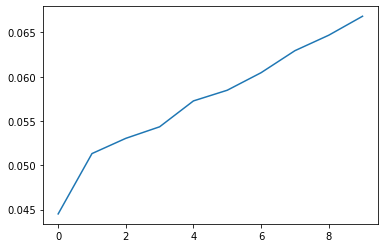

In [48]:
x = np.array(loss_hist_trials_step_1)
m = np.mean(x, axis=0)
plt.plot(m)

Text(0.5, 1.0, 'Horizon 1')

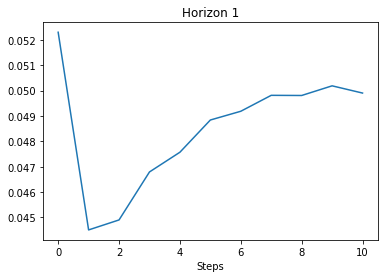

In [49]:
x = np.array(loss_hist_trials_horizon_1)
m = np.mean(x, axis=0)
plt.plot(m)
plt.xlabel("Steps")
plt.title("Horizon 1")


Text(0.5, 1.0, '10 Steps')

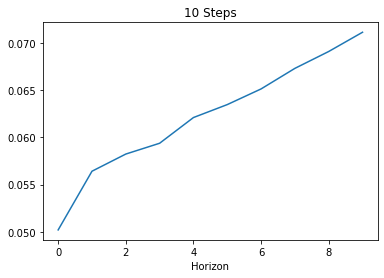

In [50]:
x = np.array(loss_hist_trials_step_10)
m = np.mean(x, axis=0)
plt.plot(m)
plt.xlabel("Horizon")
plt.title("10 Steps")

Text(0.5, 1.0, 'Horizon 10')

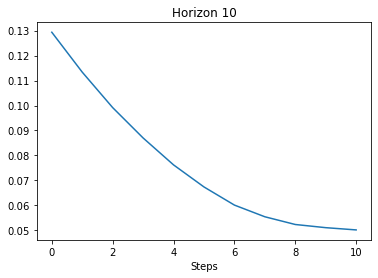

In [51]:
x = np.array(loss_hist_trials_horizon_10)
m = np.mean(x, axis=0)
plt.plot(m)
plt.xlabel("Steps")
plt.title("Horizon 10")

## Horizon, Steps Battery

In [52]:
##multimodal learner parameters
# paramters wto increase capactiy of the model
dataset_name = "BATTERY"

window_size, task_size, input_dim = meta_info[dataset_name]

train_data = pickle.load(  open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
train_data_ML = pickle.load( open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
validation_data = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
validation_data_ML = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
test_data = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
test_data_ML = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )


n_layers_task_net = 2
n_layers_task_encoder = 1
n_layers_task_decoder = 1

hidden_dim_task_net = 120
hidden_dim_encoder = 120
hidden_dim_decoder = 120

# fixed values
input_dim_task_net = input_dim
input_dim_task_encoder = input_dim + 1
output_dim_task_net = 1
output_dim_task_decoder = input_dim + 1
output_dim = 1
modulate_task_net = True



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


task_net = LSTMModel(batch_size=batch_size,
                     seq_len=window_size,
                     input_dim=input_dim_task_net,
                     n_layers=n_layers_task_net,
                     hidden_dim=hidden_dim_task_net,
                     output_dim=output_dim_task_net)

task_encoder = LSTMModel(batch_size=batch_size,
                         seq_len=task_size,
                         input_dim=input_dim_task_encoder,
                         n_layers=n_layers_task_encoder,
                         hidden_dim=hidden_dim_encoder,
                         output_dim=1)

task_decoder = LSTMDecoder(batch_size=1,
                           n_layers=n_layers_task_decoder,
                           seq_len=task_size,
                           output_dim=output_dim_task_decoder,
                           hidden_dim=hidden_dim_encoder,
                           latent_dim=hidden_dim_decoder,
                           device=device)

lmbd = Lambda(hidden_dim_encoder, hidden_dim_task_net)


multimodal_learner = MultimodalLearner(task_net, task_encoder, task_decoder, lmbd, modulate_task_net)
multimodal_learner.to(device)

output_layer = nn.Linear(120, 1)
output_layer.to(device)

maml = l2l.algorithms.MAML(output_layer, lr=learning_rate, first_order=False)
opt = optim.Adam(list(maml.parameters()) + list(multimodal_learner.parameters()), lr=meta_learning_rate)


task_data_train = torch.FloatTensor(get_task_encoder_input(train_data_ML))
task_data_validation = torch.FloatTensor(get_task_encoder_input(validation_data_ML))
task_data_test = torch.FloatTensor(get_task_encoder_input(test_data_ML))


In [53]:

learning_rate = 0.0001


loss_hist_trials_horizon_1 = []
loss_hist_trials_horizon_10 = []
loss_hist_trials_step_1 = []
loss_hist_trials_step_10 = []

loss_fn = mae

experiment_id = "21_COMPARISON"

for trial in range(3):

    
    output_directory = "../../Models/"+dataset_name+"_"+model_name+"_MMAML/"+str(trial)+"/"
    save_model_file_ = output_directory + experiment_id + "_encoder_model.pt"
    save_model_file_2 = output_directory + experiment_id + "_model.pt"



    multimodal_learner = MultimodalLearner(task_net, task_encoder, task_decoder, lmbd, modulate_task_net)
    multimodal_learner.to(device)

    output_layer = nn.Linear(120, 1)
    output_layer.to(device)

    maml = l2l.algorithms.MAML(output_layer, lr=learning_rate, first_order=False)
    
    
    multimodal_learner.load_state_dict(torch.load(save_model_file_))
    maml.load_state_dict(torch.load(save_model_file_2))
    
    print(trial)

    loss_hist_test1 =[]
    for adaptation_steps in range(0,11):
        loss = test_mmaml(loss_fn, maml, multimodal_learner, task_data_test, dataset_name, test_data_ML, adaptation_steps, learning_rate, noise_level, noise_type,horizon=1)
        loss_hist_test1.append(float(loss))
        
    loss_hist_test2 =[]
    for horizon in range(1,11):
        loss = test_mmaml(loss_fn, maml, multimodal_learner, task_data_test, dataset_name, test_data_ML, 1, learning_rate, noise_level, noise_type,horizon=horizon)        
        loss_hist_test2.append(float(loss))

        
    loss_hist_trials_horizon_1.append(loss_hist_test1)
    loss_hist_trials_step_1.append(loss_hist_test2)


experiment_id = "30_COMPARISON_3"

for trial in range(3):

    print(trial)
    output_directory = "../../Models/"+dataset_name+"_"+model_name+"_MMAML/"+str(trial)+"/"
    save_model_file_ = output_directory + experiment_id + "_encoder_model.pt"
    save_model_file_2 = output_directory + experiment_id + "_model.pt"


    multimodal_learner = MultimodalLearner(task_net, task_encoder, task_decoder, lmbd, modulate_task_net)
    multimodal_learner.to(device)

    output_layer = nn.Linear(120, 1)
    output_layer.to(device)

    maml = l2l.algorithms.MAML(output_layer, lr=learning_rate, first_order=False)
    
    
    multimodal_learner.load_state_dict(torch.load(save_model_file_))
    maml.load_state_dict(torch.load(save_model_file_2))
    
    print(trial)

    loss_hist_test1 =[]
    for adaptation_steps in range(0,11):
        loss = test_mmaml(loss_fn, maml, multimodal_learner, task_data_test, dataset_name, test_data_ML, adaptation_steps, learning_rate, noise_level, noise_type,horizon=1)
        loss_hist_test1.append(float(loss))
        
    loss_hist_test2 =[]
    for horizon in range(1,11):
        loss = test_mmaml(loss_fn, maml, multimodal_learner, task_data_test, dataset_name, test_data_ML, 10, learning_rate, noise_level, noise_type,horizon=horizon)        
        loss_hist_test2.append(float(loss))

        
        
    loss_hist_trials_horizon_10.append(loss_hist_test1) 
    loss_hist_trials_step_10.append(loss_hist_test2)


0
1
2
0
0
1
1
2
2


In [54]:
np.save( "../../Results/npy_objects/graphs_MMAML_horizon_10_"+dataset_name+".npy", loss_hist_trials_horizon_10)
np.save( "../../Results/npy_objects/graphs_MMAML_horizon_1_"+dataset_name+".npy", loss_hist_trials_horizon_1)
np.save( "../../Results/npy_objects/graphs_MMAML_step_10_"+dataset_name+".npy", loss_hist_trials_step_10)
np.save( "../../Results/npy_objects/graphs_MMAML_step_1_"+dataset_name+".npy", loss_hist_trials_step_1)

Text(0.5, 0, 'Horizon')

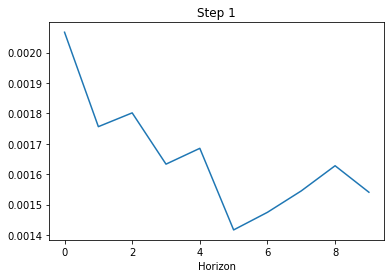

In [55]:
x = np.array(loss_hist_trials_step_1)
m = np.mean(x, axis=0)
plt.plot(m)
plt.title("Step 1")
plt.xlabel("Horizon")

Text(0.5, 1.0, 'Horizon 1')

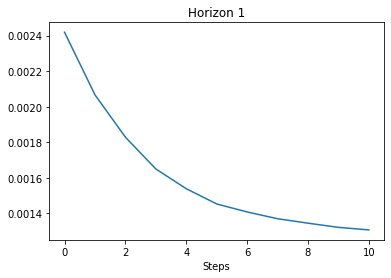

In [56]:
x = np.array(loss_hist_trials_horizon_1)
m = np.mean(x, axis=0)
plt.plot(m)
plt.xlabel("Steps")
plt.title("Horizon 1")


Text(0.5, 1.0, '10 Steps')

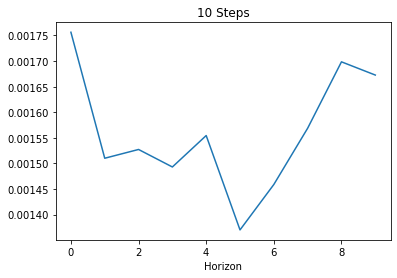

In [57]:
x = np.array(loss_hist_trials_step_10)
m = np.mean(x, axis=0)
plt.plot(m)
plt.xlabel("Horizon")
plt.title("10 Steps")

Text(0.5, 1.0, 'Horizon 10')

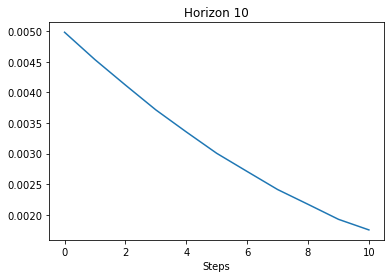

In [58]:
x = np.array(loss_hist_trials_horizon_10)
m = np.mean(x, axis=0)
plt.plot(m)
plt.xlabel("Steps")
plt.title("Horizon 10")

## Horizon, Steps Pollution

In [59]:
##multimodal learner parameters
# paramters wto increase capactiy of the model

dataset_name = "POLLUTION"
window_size, task_size, input_dim = meta_info[dataset_name]

train_data = pickle.load(  open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
train_data_ML = pickle.load( open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
validation_data = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
validation_data_ML = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
test_data = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
test_data_ML = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )

n_layers_task_net = 2
n_layers_task_encoder = 1
n_layers_task_decoder = 1

hidden_dim_task_net = 120
hidden_dim_encoder = 120
hidden_dim_decoder = 120

# fixed values
input_dim_task_net = input_dim
input_dim_task_encoder = input_dim + 1
output_dim_task_net = 1
output_dim_task_decoder = input_dim + 1
output_dim = 1
modulate_task_net = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


task_net = LSTMModel(batch_size=batch_size,
                     seq_len=window_size,
                     input_dim=input_dim_task_net,
                     n_layers=n_layers_task_net,
                     hidden_dim=hidden_dim_task_net,
                     output_dim=output_dim_task_net)

task_encoder = LSTMModel(batch_size=batch_size,
                         seq_len=task_size,
                         input_dim=input_dim_task_encoder,
                         n_layers=n_layers_task_encoder,
                         hidden_dim=hidden_dim_encoder,
                         output_dim=1)

task_decoder = LSTMDecoder(batch_size=1,
                           n_layers=n_layers_task_decoder,
                           seq_len=task_size,
                           output_dim=output_dim_task_decoder,
                           hidden_dim=hidden_dim_encoder,
                           latent_dim=hidden_dim_decoder,
                           device=device)

lmbd = Lambda(hidden_dim_encoder, hidden_dim_task_net)


multimodal_learner = MultimodalLearner(task_net, task_encoder, task_decoder, lmbd, modulate_task_net)
multimodal_learner.to(device)

output_layer = nn.Linear(120, 1)
output_layer.to(device)

maml = l2l.algorithms.MAML(output_layer, lr=learning_rate, first_order=False)
opt = optim.Adam(list(maml.parameters()) + list(multimodal_learner.parameters()), lr=meta_learning_rate)


task_data_train = torch.FloatTensor(get_task_encoder_input(train_data_ML))
task_data_validation = torch.FloatTensor(get_task_encoder_input(validation_data_ML))
task_data_test = torch.FloatTensor(get_task_encoder_input(test_data_ML))


In [60]:

learning_rate = 0.01



loss_hist_trials_horizon_1 = []
loss_hist_trials_horizon_10 = []
loss_hist_trials_step_1 = []
loss_hist_trials_step_10 = []

loss_fn = mae

experiment_id = "5_COMPARISON_2"

for trial in range(5):

    
    output_directory = "../../Models/"+dataset_name+"_"+model_name+"_MMAML/"+str(trial)+"/"
    save_model_file_ = output_directory + experiment_id + "_encoder_model.pt"
    save_model_file_2 = output_directory + experiment_id + "_model.pt"



    multimodal_learner = MultimodalLearner(task_net, task_encoder, task_decoder, lmbd, modulate_task_net)
    multimodal_learner.to(device)

    output_layer = nn.Linear(120, 1)
    output_layer.to(device)

    maml = l2l.algorithms.MAML(output_layer, lr=learning_rate, first_order=False)
    
    
    multimodal_learner.load_state_dict(torch.load(save_model_file_))
    maml.load_state_dict(torch.load(save_model_file_2))
    
    print(trial)

    loss_hist_test1 =[]
    for adaptation_steps in range(0,11):
        loss = test_mmaml(loss_fn, maml, multimodal_learner, task_data_test, dataset_name, test_data_ML, adaptation_steps, learning_rate, noise_level, noise_type,horizon=1)
        loss_hist_test1.append(float(loss))
        
    loss_hist_test2 =[]
    for horizon in range(1,11):
        loss = test_mmaml(loss_fn, maml, multimodal_learner, task_data_test, dataset_name, test_data_ML, 1, learning_rate, noise_level, noise_type,horizon=horizon)        
        loss_hist_test2.append(float(loss))

        
    loss_hist_trials_horizon_1.append(loss_hist_test1)
    loss_hist_trials_step_1.append(loss_hist_test2)


experiment_id = "6_COMPARISON_2"
learing_rate = 0.001
for trial in range(5):

    print(trial)
    output_directory = "../../Models/"+dataset_name+"_"+model_name+"_MMAML/"+str(trial)+"/"
    save_model_file_ = output_directory + experiment_id + "_encoder_model.pt"
    save_model_file_2 = output_directory + experiment_id + "_model.pt"


    multimodal_learner = MultimodalLearner(task_net, task_encoder, task_decoder, lmbd, modulate_task_net)
    multimodal_learner.to(device)

    output_layer = nn.Linear(120, 1)
    output_layer.to(device)

    maml = l2l.algorithms.MAML(output_layer, lr=learning_rate, first_order=False)
    
    
    multimodal_learner.load_state_dict(torch.load(save_model_file_))
    maml.load_state_dict(torch.load(save_model_file_2))
    
    print(trial)

    loss_hist_test1 =[]
    for adaptation_steps in range(0,11):
        loss = test_mmaml(loss_fn, maml, multimodal_learner, task_data_test, dataset_name, test_data_ML, adaptation_steps, learning_rate, noise_level, noise_type,horizon=1)
        loss_hist_test1.append(float(loss))
        
    loss_hist_test2 =[]
    for horizon in range(1,11):
        loss = test_mmaml(loss_fn, maml, multimodal_learner, task_data_test, dataset_name, test_data_ML, 10, learning_rate, noise_level, noise_type,horizon=horizon)        
        loss_hist_test2.append(float(loss))

        
        
    loss_hist_trials_horizon_10.append(loss_hist_test1) 
    loss_hist_trials_step_10.append(loss_hist_test2)


0
1
2
3
4
0
0
1
1
2
2
3
3
4
4


In [61]:
np.save( "../../Results/npy_objects/graphs_MMAML_horizon_10_"+dataset_name+".npy", loss_hist_trials_horizon_10)
np.save( "../../Results/npy_objects/graphs_MMAML_horizon_1_"+dataset_name+".npy", loss_hist_trials_horizon_1)
np.save( "../../Results/npy_objects/graphs_MMAML_step_10_"+dataset_name+".npy", loss_hist_trials_step_10)
np.save( "../../Results/npy_objects/graphs_MMAML_step_1_"+dataset_name+".npy", loss_hist_trials_step_1)

Text(0.5, 0, 'Horizon')

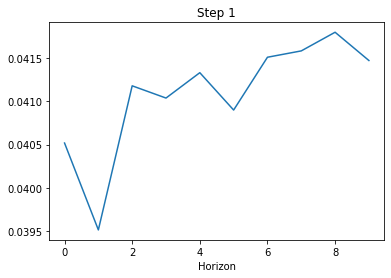

In [62]:
x = np.array(loss_hist_trials_step_1)
m = np.mean(x, axis=0)
plt.plot(m)
plt.title("Step 1")
plt.xlabel("Horizon")

Text(0.5, 1.0, 'Horizon 1')

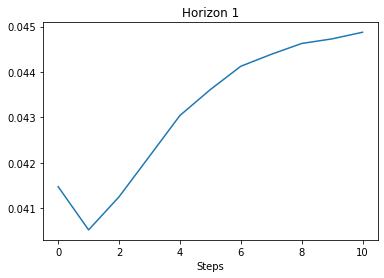

In [63]:
x = np.array(loss_hist_trials_horizon_1)
m = np.mean(x, axis=0)
plt.plot(m)
plt.xlabel("Steps")
plt.title("Horizon 1")


Text(0.5, 1.0, '10 Steps')

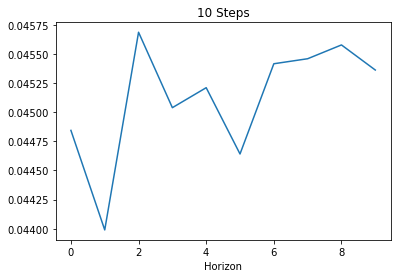

In [64]:
x = np.array(loss_hist_trials_step_10)
m = np.mean(x, axis=0)
plt.plot(m)
plt.xlabel("Horizon")
plt.title("10 Steps")

Text(0.5, 1.0, 'Horizon 10')

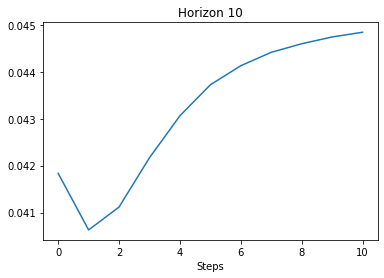

In [65]:
x = np.array(loss_hist_trials_horizon_10)
m = np.mean(x, axis=0)
plt.plot(m)
plt.xlabel("Steps")
plt.title("Horizon 10")